In [37]:
import math
from pathlib import Path
from zipfile import ZipFile
import matplotlib.pyplot as plt
import contextily as ctx

import geopy
import shapely
import numpy as np
import geopandas as gpd
from geopy import distance

import fiona
from fiona import transform
from cpp_algorithms import imshow, imshow_scatter
from cpp_algorithms.rasterize.rasterize import rasterize

In [12]:
from cpp_algorithms import conversion

In [136]:
# Created shapfies have these valeus in the type column
EPSG=4326
FEATURES = ["coverage", "obstacle", "fuel", "drone"]

def read_shapefile(path, to_del=False):
    """
    Path of the zip file containing the .shp
    """
    path = Path(path)
    ZipFile(path).extractall(path.parent)
    shp_all = []
    for shfile in (path.parent/"layers").iterdir():
        if shfile.suffix == ".shp":
            shp_all.append(gpd.read_file(shfile))
    if to_del:
        (path.parent/"layers").unlink()
    return shp_all

def get_features_dict(shape_files, key='type', fnames=FEATURES):
    """
    Name of the features should be shapefile 
    `key` column values
    """
    features = {}
    for name in fnames:
        features[name] = []
        
    for sh in shape_files:
        for rows in sh.iterrows():
            for k in features:
                if rows[1][key].find(k) >= 0:
                    features[k].append(rows[1].geometry)
    return features

def get_final_coverage_polygon(features):
    """
    Union of coverage and difference of
    obstacles.
    """
    final = features['coverage'][0]
    for cov in features['coverage']:
        final = final.union(cov)
    for obs in features['obstacle']:
        final = final.difference(obs)
    return final

def get_bounding_points(final_coverage):
    """
    lower left, top left, top right, lower right
    """
    llng, llat, rlng, rlat =  final_coverage.bounds
    ll = (llat,llng)
    tl = (rlat,llng)
    tr = (rlat,rlng)
    lr = (llat,rlng)
    return {
        'll':ll,
        'tl':tl,
        'tr':tr,
        'lr':lr
    }

def get_bounding_poly(final_coverage):
    """
    shapely polygon that bound the `final_coverage`
    polygon of the coverage area.
    """
    return final_coverage.envelope

def get_hv_wh(final_coverage):
    """
    Get haversine calcualted width and height of
    the smallest bounding rectangle of final_coverage.
    """
    llng, llat, rlng, rlat =  final_coverage.bounds
    ll = (llat,llng)
    lr = (llat,rlng)
    tr = (rlat,rlng)
    tl = (rlat,llng)
    w = distance.distance(ll,lr)
    h = distance.distance(ll,tl)
    return w, h

def grid_size(side, final_coverage, returnwh=False):
    """
    side : cell side in meters
    final_coverage : area of coverage polygon
    returnwh : True – returns the haversine 
        w,h of the bounding box 
    """
    w, h = get_hv_wh(final_coverage)
    w_count = math.ceil(w.m/side)
    h_count = math.ceil(h.m/side)
    if returnwh:
        return w_count, h_count, w, h
    return w_count, h_count

def create_gdframe(features, crs=f"EPSG:{EPSG}", no_points=False):
    """
    Create GeoDataFrame from features
    """
    final_coverage = get_final_coverage_polygon(features)
    points = []
    if not no_points:
        for d in features['drone']:
            points.append({
                'type':'drone',
                'geometry':d
            })
        for f in features['fuel']:
            points.append({
                'type':'fuel',
                'geometry':d
            })
    points.append({
        'type':'coverage',
        'geometry':final_coverage})
    return gpd.GeoDataFrame(points, crs=crs)

(72.78930759429932, 72.85180950164795, 18.91483027045598, 19.030543097510375)

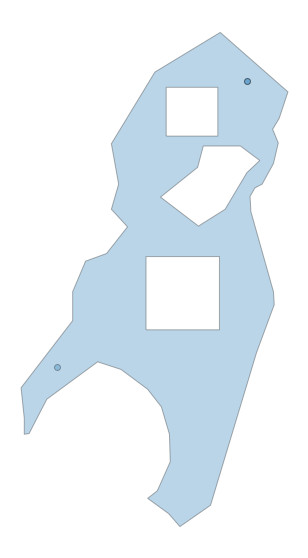

In [14]:
cside = 100 # coverage side in meters
cside = geopy.distance.distance(meters=cside)
shape_files = read_shapefile("sandbox/mapme_1.zip")
features = get_features_dict(shape_files)
final_coverage = get_final_coverage_polygon(features)
bounding_poly = get_bounding_poly(final_coverage)
bpoints = get_bounding_points(final_coverage)
w, h = get_hv_wh(final_coverage)
fgd_frame = create_gdframe(features)
fgd_frame.plot(figsize=(10,10),alpha=0.3,edgecolor='k')
plt.axis('off')

In [15]:
shape_files[0]

,stroke,stroke-w,stroke-o,fill,fill-opa,type,geometry
0,#555555,2,1,#555555,0,coverage,"POLYGON ((72.83455 19.02528, 72.82064 19.01684..."
1,#555555,2,1,#555555,0,obstacle,"POLYGON ((72.82305 19.00321, 72.83403 19.00321..."
2,#555555,2,1,#555555,0,obstacle,"POLYGON ((72.81876 18.96198, 72.83438 18.96198..."
3,#555555,2,1,#555555,0,obstacle ...,"POLYGON ((72.82974 18.99656, 72.82185 18.99023..."


In [16]:
shape_files[1]

,marker-c,marker-s,type,geometry
0,#7e7e7e,0,drone,POINT (72.79987 18.95386)
1,#7e7e7e,0,drone,POINT (72.84039 19.01473)
2,#7e7e7e,0,fuel ...,POINT (72.81790 18.98357)


In [152]:
area_map, points = conversion(100, shape_files)

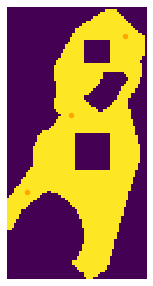

In [18]:
imshow(area_map)
imshow_scatter(points)

In [38]:
def get_points_dict(features, points_keys = ['drone', 'fuel']):
    points = {
        "type":[],
        "points":[]
        
    }
    for key in points_keys:
        for point in features[key]:
            points['type'].append(key)
            points['points'].append(point)
        
    return points

In [41]:
def get_square(ll, side):
    # returns the points of a square.
    points = [ll]
    points.append(side.destination(ll,0))
    points.append(side.destination(points[1],90))
    points.append(side.destination(ll,90))
    return points

In [42]:
def get_lat_lng(point):
    """
    From geopy points
    """
    return point.latitude, point.longitude

In [43]:
def get_grid_lines(side, final_coverage):
    """
    side : drone coverage square side
    final_coverage : coverage_area
    
    returns a Grid for the bounding box
    """
    P = lambda p: geopy.point.Point(p)
    ltlg = lambda p: (p.latitude, p.longitude)
    lglt = lambda p: (p.longitude, p.latitude)
    
    width, height = grid_size(side, final_coverage)
    side = geopy.distance.distance(meters=side)
    bpoints = get_bounding_points(final_coverage)
    
    ll = bpoints['ll']
    tl = ltlg((side*height).destination(P(ll),0))
    gline = shapely.geometry.LineString([ll[::-1],tl[::-1]])
    prev_pair = (P(ll),P(tl))
    
    # Vertical lines
    for w in range(width):
        ll, tl = prev_pair
        nll = side.destination(ll,90)
        ntl = side.destination(tl,90)
        prev_pair = (nll,ntl)
        nll = lglt(nll)
        ntl = lglt(ntl)
        gline = gline.union(shapely.geometry.LineString([ntl,nll]))

    ll = bpoints['ll']
    lr = ltlg((side*width).destination(P(ll),90))
    gline = gline.union(shapely.geometry.LineString([ll[::-1],lr[::-1]]))
    prev_pair = (P(ll),P(lr))

    # Horizontal lines
    for h in range(height):
        ll, lr = prev_pair
        nll = side.destination(ll,0)
        nlr = side.destination(lr,0)
        prev_pair = (nll,nlr)
        nll = lglt(nll)
        nlr = lglt(nlr)
        gline = gline.union(shapely.geometry.LineString([nll,nlr]))
    return gline

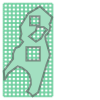

In [44]:
grid = get_grid_lines(500, final_coverage)
grid_intersec = grid.intersection(final_coverage)
grid.union(final_coverage)

In [45]:
def grid_points(side, coverage_area):
    """
    side : drone coverage square side
    coverage_area : area to be covered by the drone
    """
    width, height = grid_size(side, coverage_area)
    side = geopy.distance.distance(meters=side)
    bpoints = get_bounding_points(coverage_area)
    

    latitudes = []
    start = geopy.Point(bpoints['ll'])
    for _ in range(height):
        latitudes.append(start)
        final = side.destination(point=start, bearing=0)
        start = final
    latitudes.append(start)
    
    longitudes = []
    start = geopy.Point(bpoints['ll'])
    for _ in range(width):
        longitudes.append(start)
        final = side.destination(point=start, bearing=90)
        start = final
    longitudes.append(start)
    
    return latitudes, longitudes, height, width

def rasterize(side, coverage_area, start_points):
    """
    side : side of the drone in meters
    coverage_area : area to be covered by the drone
    """
    
    outside_map_traverse_area = coverage_area.envelope.difference(coverage_area)
    latitudes,longitudes,height,width = grid_points(side, coverage_area)
    lookup_c = np.zeros([height,width],dtype = 'O')
    raster = np.zeros([height, width],dtype = int)
    start_coords = []
    
    
    for x in range(len(latitudes)-1):
        for y in range(len(longitudes)-1):
            square = shapely.geometry.Polygon([(longitudes[y][1],latitudes[height-x][0]),\
                              (longitudes[y+1][1],latitudes[height-x][0]),\
                              (longitudes[y+1][1],latitudes[height-x-1][0]),\
                              (longitudes[y][1],latitudes[height-x-1][0])]) 
            for start_point in start_points:
                if(start_point.within(square)):
                    start_coords.append((x,y))
                    
            lookup_c[x,y] = square.centroid
            # storing value of centre point
            if(outside_map_traverse_area.contains(square)):
                raster[x,y] = -1  # region outside the map but inside the gird
            if(square.intersects(coverage_area)):
                    z = square.intersection(coverage_area)
                    if(not z.is_empty):
                        if(coverage_area.contains(z)):
                            raster[x,y] = 0 #region inside the map
                        else:
                            raster[x,y] = 0 #2 is for boundary partial
                            
    raster[0] = -1
    raster[:,-1] = -1
    return raster, start_coords

(233, 120)


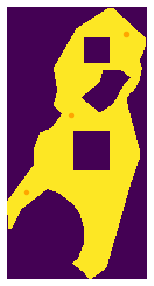

In [49]:
# temp = matrix_lookup(50, features['coverage'][0])
temp, start_points = rasterize(50, final_coverage,[*features['drone'],*features['fuel']])

print(temp.shape)

imshow(temp)
imshow_scatter(start_points)

In [50]:
def get_mask(poly, h, w):
    """
    Returns a boolean mask
    """
    y,x = np.mgrid[:h,:w] # Creates a mesh grid
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # stacks the meshgrids side by side
    mask = Path(poly).contains_points(coors).reshape(h,w)
    return mask

In [137]:
def get_raster(shape_files, epsg=EPSG, scaler=2):
    """
    Returns a rasterised image
    """
    features = get_features_dict(shape_files)
    final_coverage = get_final_coverage_polygon(features)
    w,h = get_hv_wh(final_coverage)
    fc_gpd = create_gdframe(features, no_points=True)
    ax = fc_gpd.plot(figsize=(w.km*scaler,h.km*scaler))
    plt.axis('off')
    ax.figure.canvas.draw()
    data = np.frombuffer(ax.figure.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(ax.figure.canvas.get_width_height()[::-1]+(3,))
    data = data.mean(axis=2)
    data[data == 110] = 0
    data[data == 255] = -1
    x,y = np.where(data == 0)
    data = data[x.min():x.max(),y.min():y.max()]
    ax.figure.clear()
    return data

In [153]:
w.m/y, h.m/x

(10.179478099035746, 10.125260603283568)

In [151]:
get_raster(shape_files).shape

(1150, 588)

<Figure size 861.917x1676.74 with 0 Axes>